In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

2024-11-16 20:19:49.486895: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-16 20:19:49.492320: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-16 20:19:49.504486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 20:19:49.525622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 20:19:49.531381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 20:19:49.545678: I tensorflow/core/platform/cpu_feature_gu

In [5]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Download less data
ticker = "AAPL"
stock = yf.Ticker(ticker)
data = stock.history(period="1y")['Close']  # Only 1 year of data

# Calculate returns
returns = data.pct_change().dropna()

# Normalize returns
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_returns = scaler.fit_transform(returns.values.reshape(-1, 1))

In [8]:
class MiniTimeSeriesGAN:
    def __init__(self):
        self.generator = tf.keras.Sequential([
            layers.Dense(32, input_dim=10),
            layers.LeakyReLU(0.2),
            layers.Dense(1, activation='tanh')
        ])
        
        self.discriminator = tf.keras.Sequential([
            layers.Dense(32, input_dim=1),
            layers.LeakyReLU(0.2),
            layers.Dense(1, activation='sigmoid')
        ])
        
    def train(self, real_data, epochs=100, batch_size=32):
        for epoch in range(epochs):
            # Train discriminator
            idx = np.random.randint(0, len(real_data), batch_size)
            real_batch = real_data[idx]
            
            noise = tf.random.normal([batch_size, 10])
            generated_data = self.generator(noise)
            
            with tf.GradientTape() as disc_tape:
                real_output = self.discriminator(real_batch)
                fake_output = self.discriminator(generated_data)
                
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )
            
            # Train generator
            noise = tf.random.normal([batch_size, 10])
            with tf.GradientTape() as gen_tape:
                generated_data = self.generator(noise)
                fake_output = self.discriminator(generated_data)
                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
            
            # Update weights
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            
            tf.keras.optimizers.Adam(1e-4).apply_gradients(
                zip(disc_grads, self.discriminator.trainable_variables))
            tf.keras.optimizers.Adam(1e-4).apply_gradients(
                zip(gen_grads, self.generator.trainable_variables))
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}')

In [11]:
# Create and train GAN
gan = MiniTimeSeriesGAN()
gan.train(scaled_returns, epochs=100)  # Reduced epochs

# Generate returns
n_samples = 200
noise = tf.random.normal([n_samples, 10])
generated_returns = gan.generator(noise).numpy()
generated_returns = scaler.inverse_transform(generated_returns)

/home/c47e0470-b83d-48c6-a026-413daab4c753/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0, Gen Loss: 0.7268, Disc Loss: 1.3693
Epoch 10, Gen Loss: 0.7349, Disc Loss: 1.3745
Epoch 20, Gen Loss: 0.7282, Disc Loss: 1.3679
Epoch 30, Gen Loss: 0.7348, Disc Loss: 1.3746
Epoch 40, Gen Loss: 0.7295, Disc Loss: 1.3638
Epoch 50, Gen Loss: 0.7292, Disc Loss: 1.3692
Epoch 60, Gen Loss: 0.7280, Disc Loss: 1.3627
Epoch 70, Gen Loss: 0.7302, Disc Loss: 1.3610
Epoch 80, Gen Loss: 0.7388, Disc Loss: 1.3657
Epoch 90, Gen Loss: 0.7258, Disc Loss: 1.3668


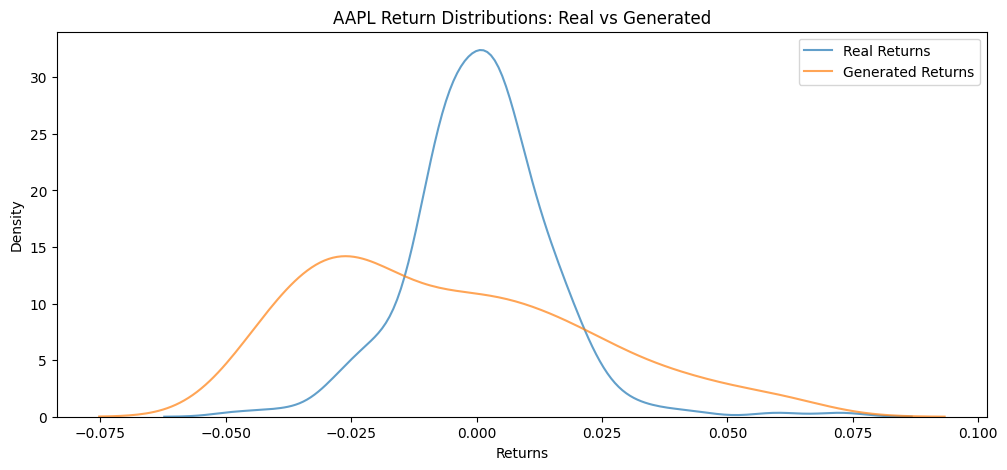


Statistical Comparison:
Real Returns:
Mean: 0.000799
Std: 0.014195

Generated Returns:
Mean: -0.005665
Std: 0.027498


In [14]:
# Plotting
plt.figure(figsize=(12, 5))
sns.kdeplot(data=returns, label='Real Returns', alpha=0.7)
sns.kdeplot(data=generated_returns.flatten(), label='Generated Returns', alpha=0.7)
plt.title(f'{ticker} Return Distributions: Real vs Generated')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

# Print basic statistics
print("\nStatistical Comparison:")
print("=" * 30)
print("Real Returns:")
print(f"Mean: {returns.mean():.6f}")
print(f"Std: {returns.std():.6f}")

print("\nGenerated Returns:")
print(f"Mean: {generated_returns.mean():.6f}")
print(f"Std: {generated_returns.std():.6f}")